# Airbnb Booking Destination Prediction

In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

In [55]:
!pip install xgboost

     |████████████████████████████████| 297.1 MB 105.9 MB/s eta 0:00:01  |█▍                              | 13.2 MB 28.2 MB/s eta 0:00:11

File Descriptions:

1. `train_users.csv` - Contains the training set of users with the following columns:
   - `id`: User ID
   - `date_account_created`: Date of account creation
   - `timestamp_first_active`: Timestamp of the first activity (can be earlier than `date_account_created` or `date_first_booking` because a user can search before signing up)
   - `date_first_booking`: Date of first booking (target variable, not available in the test set)
   - `gender`
   - `age`
   - `signup_method`
   - `signup_flow`: The page a user came to sign up from
   - `language`: International language preference
   - `affiliate_channel`: Type of paid marketing
   - `affiliate_provider`: Marketing provider (e.g., google, craigslist, etc.)
   - `first_affiliate_tracked`: First marketing the user interacted with before signing up
   - `signup_app`
   - `first_device_type`
   - `first_browser`
   - `country_destination`: The target variable to predict

2. `test_users.csv` - Contains the test set of users, similar to `train_users.csv` but without the `country_destination` column.


4. `countries.csv` - Contains summary statistics of destination countries in this dataset and their locations.



In [1]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings/data'
od.download(dataset_url)


Skipping, found downloaded files in "./airbnb-recruiting-new-user-bookings" (use force=True to force download)


In [2]:
!cd airbnb-recruiting-new-user-bookings/test_users.csv.zip

/bin/bash: line 0: cd: airbnb-recruiting-new-user-bookings/test_users.csv.zip: Not a directory


In [3]:
!unzip airbnb-recruiting-new-user-bookings/train_users_2.csv.zip

Archive:  airbnb-recruiting-new-user-bookings/train_users_2.csv.zip
replace train_users_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
!unzip airbnb-recruiting-new-user-bookings/countries.csv.zip

Archive:  airbnb-recruiting-new-user-bookings/countries.csv.zip
replace countries.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Data Exploration and Understanding:
   - Load the datasets and explore the data to understand its structure, features, and relationships.
   - Check for missing values, data types, and outliers.
   - Explore summary statistics and distributions of numerical features.


In [29]:
import pandas as pd
train_df=pd.read_csv("train_users_2.csv")

In [30]:
train_df

id date_account_created  timestamp_first_active  \
0       gxn3p5htnn           2010-06-28          20090319043255   
1       820tgsjxq7           2011-05-25          20090523174809   
2       4ft3gnwmtx           2010-09-28          20090609231247   
3       bjjt8pjhuk           2011-12-05          20091031060129   
4       87mebub9p4           2010-09-14          20091208061105   
...            ...                  ...                     ...   
213446  zxodksqpep           2014-06-30          20140630235636   
213447  mhewnxesx9           2014-06-30          20140630235719   
213448  6o3arsjbb4           2014-06-30          20140630235754   
213449  jh95kwisub           2014-06-30          20140630235822   
213450  nw9fwlyb5f           2014-06-30          20140630235824   

       date_first_booking     gender   age signup_method  signup_flow  \
0                     NaN  -unknown-   NaN      facebook            0   
1                     NaN       MALE  38.0      facebook            0   
2              2010-08-02     FEMALE  56.0         basic            3   
3              2012-09-08     FEMALE  42.0      facebook            0   
4              2010-02-18  -unknown-  41.0         basic            0   
...                   ...        ...   ...           ...          ...   
213446                NaN       MALE  32.0         basic            0   
213447                NaN  -unknown-   NaN         basic            0   
213448                NaN  -unknown-  32.0         basic            0   
213449                NaN  -unknown-   NaN         basic           25   
213450                NaN  -unknown-   NaN         basic           25   

       language affiliate_channel affiliate_provider first_affiliate_tracked  \
0            en            direct             direct               untracked   
1            en               seo             google               untracked   
2            en            direct             direct               untracked   
3            en            direct             direct               untracked   
4            en            direct             direct               untracked   
...         ...               ...                ...                     ...   
213446       en         sem-brand             google                     omg   
213447       en            direct             direct                  linked   
213448       en            direct             direct               untracked   
213449       en             other              other           tracked-other   
213450       en            direct             direct               untracked   

       signup_app first_device_type  first_browser country_destination  
0             Web       Mac Desktop         Chrome                 NDF  
1             Web       Mac Desktop         Chrome                 NDF  
2             Web   Windows Desktop             IE                  US  
3             Web       Mac Desktop        Firefox               other  
4             Web       Mac Desktop         Chrome                  US  
...           ...               ...            ...                 ...  
213446        Web       Mac Desktop         Safari                 NDF  
213447        Web   Windows Desktop         Chrome                 NDF  
213448        Web       Mac Desktop        Firefox                 NDF  
213449        iOS            iPhone  Mobile Safari                 NDF  
213450        iOS            iPhone      -unknown-                 NDF  

[213451 rows x 16 columns]

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [32]:
country_df=pd.read_csv("countries.csv")

In [33]:
country_df

country_destination  lat_destination  lng_destination  distance_km  \
0                  AU       -26.853388       133.275160   15297.7440   
1                  CA        62.393303       -96.818146    2828.1333   
2                  DE        51.165707        10.452764    7879.5680   
3                  ES        39.896027        -2.487694    7730.7240   
4                  FR        46.232193         2.209667    7682.9450   
5                  GB        54.633220        -3.432277    6883.6590   
6                  IT        41.873990        12.564167    8636.6310   
7                  NL        52.133057         5.295250    7524.3203   
8                  PT        39.553444        -7.839319    7355.2534   
9                  US        36.966427       -95.844030       0.0000   

   destination_km2 destination_language   language_levenshtein_distance  
0        7741220.0                   eng                           0.00  
1        9984670.0                   eng                           0.00  
2         357022.0                   deu                          72.61  
3         505370.0                   spa                          92.25  
4         643801.0                   fra                          92.06  
5         243610.0                   eng                           0.00  
6         301340.0                   ita                          89.40  
7          41543.0                   nld                          63.22  
8          92090.0                   por                          95.45  
9        9826675.0                   eng                           0.00


### **Data Cleaning and Preprocessing**:
   - Handle missing values, potentially by imputation or removal of rows/columns.
   - Address any outliers or anomalies in the data.
   - Convert categorical variables to a suitable format for modeling (e.g., one-hot encoding or label encoding).

In [34]:
train_df.drop(columns=["date_first_booking"])

id date_account_created  timestamp_first_active     gender  \
0       gxn3p5htnn           2010-06-28          20090319043255  -unknown-   
1       820tgsjxq7           2011-05-25          20090523174809       MALE   
2       4ft3gnwmtx           2010-09-28          20090609231247     FEMALE   
3       bjjt8pjhuk           2011-12-05          20091031060129     FEMALE   
4       87mebub9p4           2010-09-14          20091208061105  -unknown-   
...            ...                  ...                     ...        ...   
213446  zxodksqpep           2014-06-30          20140630235636       MALE   
213447  mhewnxesx9           2014-06-30          20140630235719  -unknown-   
213448  6o3arsjbb4           2014-06-30          20140630235754  -unknown-   
213449  jh95kwisub           2014-06-30          20140630235822  -unknown-   
213450  nw9fwlyb5f           2014-06-30          20140630235824  -unknown-   

         age signup_method  signup_flow language affiliate_channel  \
0        NaN      facebook            0       en            direct   
1       38.0      facebook            0       en               seo   
2       56.0         basic            3       en            direct   
3       42.0      facebook            0       en            direct   
4       41.0         basic            0       en            direct   
...      ...           ...          ...      ...               ...   
213446  32.0         basic            0       en         sem-brand   
213447   NaN         basic            0       en            direct   
213448  32.0         basic            0       en            direct   
213449   NaN         basic           25       en             other   
213450   NaN         basic           25       en            direct   

       affiliate_provider first_affiliate_tracked signup_app  \
0                  direct               untracked        Web   
1                  google               untracked        Web   
2                  direct               untracked        Web   
3                  direct               untracked        Web   
4                  direct               untracked        Web   
...                   ...                     ...        ...   
213446             google                     omg        Web   
213447             direct                  linked        Web   
213448             direct               untracked        Web   
213449              other           tracked-other        iOS   
213450             direct               untracked        iOS   

       first_device_type  first_browser country_destination  
0            Mac Desktop         Chrome                 NDF  
1            Mac Desktop         Chrome                 NDF  
2        Windows Desktop             IE                  US  
3            Mac Desktop        Firefox               other  
4            Mac Desktop         Chrome                  US  
...                  ...            ...                 ...  
213446       Mac Desktop         Safari                 NDF  
213447   Windows Desktop         Chrome                 NDF  
213448       Mac Desktop        Firefox                 NDF  
213449            iPhone  Mobile Safari                 NDF  
213450            iPhone      -unknown-                 NDF  

[213451 rows x 15 columns]

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

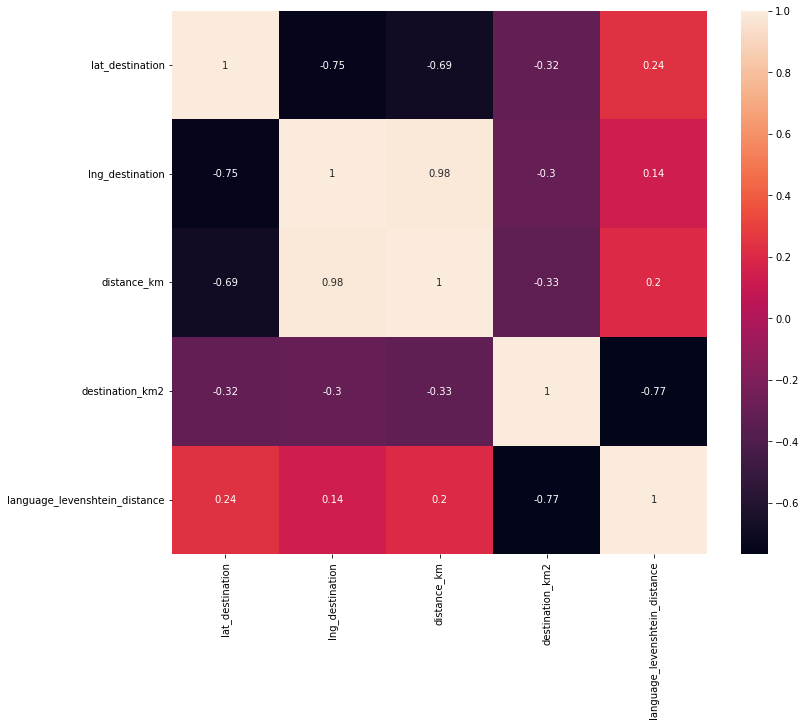

In [36]:
plt.figure(figsize=(12,10))
sns.heatmap(country_df.corr(),annot=True)

In [37]:
train_df.describe()

timestamp_first_active            age    signup_flow
count            2.134510e+05  125461.000000  213451.000000
mean             2.013085e+13      49.668335       3.267387
std              9.253717e+09     155.666612       7.637707
min              2.009032e+13       1.000000       0.000000
25%              2.012123e+13      28.000000       0.000000
50%              2.013091e+13      34.000000       0.000000
75%              2.014031e+13      43.000000       0.000000
max              2.014063e+13    2014.000000      25.000000

In [38]:
train_df.age.value_counts()

30.0      6124
31.0      6016
29.0      5963
28.0      5939
32.0      5855
          ... 
1925.0       1
1935.0       1
1933.0       1
112.0        1
1926.0       1
Name: age, Length: 127, dtype: int64

In [39]:
filter_age= train_df[train_df['age'] <= 100]

In [40]:
filter_age.age.value_counts()

30.0    6124
31.0    6016
29.0    5963
28.0    5939
32.0    5855
        ... 
97.0      10
15.0       8
2.0        7
4.0        3
1.0        2
Name: age, Length: 90, dtype: int64

<AxesSubplot:xlabel='age', ylabel='Count'>

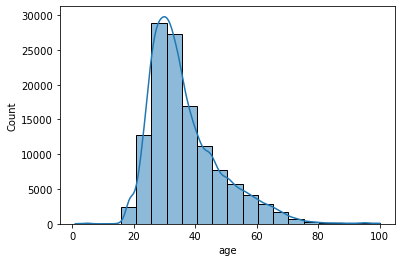

In [41]:
sns.histplot(filter_age['age'], kde=True,bins=20)

In [42]:
filter_age

id date_account_created  timestamp_first_active  \
1       820tgsjxq7           2011-05-25          20090523174809   
2       4ft3gnwmtx           2010-09-28          20090609231247   
3       bjjt8pjhuk           2011-12-05          20091031060129   
4       87mebub9p4           2010-09-14          20091208061105   
6       lsw9q7uk0j           2010-01-02          20100102012558   
...            ...                  ...                     ...   
213441  omlc9iku7t           2014-06-30          20140630235151   
213443  0k26r3mir0           2014-06-30          20140630235340   
213445  qbxza0xojf           2014-06-30          20140630235547   
213446  zxodksqpep           2014-06-30          20140630235636   
213448  6o3arsjbb4           2014-06-30          20140630235754   

       date_first_booking     gender   age signup_method  signup_flow  \
1                     NaN       MALE  38.0      facebook            0   
2              2010-08-02     FEMALE  56.0         basic            3   
3              2012-09-08     FEMALE  42.0      facebook            0   
4              2010-02-18  -unknown-  41.0         basic            0   
6              2010-01-05     FEMALE  46.0         basic            0   
...                   ...        ...   ...           ...          ...   
213441         2014-08-13     FEMALE  34.0         basic            0   
213443         2014-07-13     FEMALE  36.0         basic            0   
213445         2014-07-02     FEMALE  23.0         basic            0   
213446                NaN       MALE  32.0         basic            0   
213448                NaN  -unknown-  32.0         basic            0   

       language affiliate_channel affiliate_provider first_affiliate_tracked  \
1            en               seo             google               untracked   
2            en            direct             direct               untracked   
3            en            direct             direct               untracked   
4            en            direct             direct               untracked   
6            en             other         craigslist               untracked   
...         ...               ...                ...                     ...   
213441       en            direct             direct                  linked   
213443       en         sem-brand             google                  linked   
213445       en         sem-brand             google                     omg   
213446       en         sem-brand             google                     omg   
213448       en            direct             direct               untracked   

       signup_app first_device_type first_browser country_destination  
1             Web       Mac Desktop        Chrome                 NDF  
2             Web   Windows Desktop            IE                  US  
3             Web       Mac Desktop       Firefox               other  
4             Web       Mac Desktop        Chrome                  US  
6             Web       Mac Desktop        Safari                  US  
...           ...               ...           ...                 ...  
213441        Web       Mac Desktop        Chrome                  ES  
213443        Web       Mac Desktop        Safari                  US  
213445        Web   Windows Desktop            IE                  US  
213446        Web       Mac Desktop        Safari                 NDF  
213448        Web       Mac Desktop       Firefox                 NDF  

[123116 rows x 16 columns]

In [43]:
filter_age.drop(columns=['id','date_account_created','timestamp_first_active','date_first_booking','gender','language','first_affiliate_tracked'],inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
filter_age

age signup_method  signup_flow affiliate_channel affiliate_provider  \
1       38.0      facebook            0               seo             google   
2       56.0         basic            3            direct             direct   
3       42.0      facebook            0            direct             direct   
4       41.0         basic            0            direct             direct   
6       46.0         basic            0             other         craigslist   
...      ...           ...          ...               ...                ...   
213441  34.0         basic            0            direct             direct   
213443  36.0         basic            0         sem-brand             google   
213445  23.0         basic            0         sem-brand             google   
213446  32.0         basic            0         sem-brand             google   
213448  32.0         basic            0            direct             direct   

       signup_app first_device_type first_browser country_destination  
1             Web       Mac Desktop        Chrome                 NDF  
2             Web   Windows Desktop            IE                  US  
3             Web       Mac Desktop       Firefox               other  
4             Web       Mac Desktop        Chrome                  US  
6             Web       Mac Desktop        Safari                  US  
...           ...               ...           ...                 ...  
213441        Web       Mac Desktop        Chrome                  ES  
213443        Web       Mac Desktop        Safari                  US  
213445        Web   Windows Desktop            IE                  US  
213446        Web       Mac Desktop        Safari                 NDF  
213448        Web       Mac Desktop       Firefox                 NDF  

[123116 rows x 9 columns]

In [48]:
df_encoded = pd.get_dummies(filter_age, columns=['signup_method', 'affiliate_channel', 'affiliate_provider','signup_app','first_browser','first_device_type'])


3. **Feature Engineering**:
   - Create new features that might provide additional information or insights.
   - Extract relevant information from timestamp and date columns.
   - Combine or transform existing features to improve predictive power.

In [49]:
df_encoded

age  signup_flow country_destination  signup_method_basic  \
1       38.0            0                 NDF                    0   
2       56.0            3                  US                    1   
3       42.0            0               other                    0   
4       41.0            0                  US                    1   
6       46.0            0                  US                    1   
...      ...          ...                 ...                  ...   
213441  34.0            0                  ES                    1   
213443  36.0            0                  US                    1   
213445  23.0            0                  US                    1   
213446  32.0            0                 NDF                    1   
213448  32.0            0                 NDF                    1   

        signup_method_facebook  signup_method_google  affiliate_channel_api  \
1                            1                     0                      0   
2                            0                     0                      0   
3                            1                     0                      0   
4                            0                     0                      0   
6                            0                     0                      0   
...                        ...                   ...                    ...   
213441                       0                     0                      0   
213443                       0                     0                      0   
213445                       0                     0                      0   
213446                       0                     0                      0   
213448                       0                     0                      0   

        affiliate_channel_content  affiliate_channel_direct  \
1                               0                         0   
2                               0                         1   
3                               0                         1   
4                               0                         1   
6                               0                         0   
...                           ...                       ...   
213441                          0                         1   
213443                          0                         0   
213445                          0                         0   
213446                          0                         0   
213448                          0                         1   

        affiliate_channel_other  ...  first_browser_wOSBrowser  \
1                             0  ...                         0   
2                             0  ...                         0   
3                             0  ...                         0   
4                             0  ...                         0   
6                             1  ...                         0   
...                         ...  ...                       ...   
213441                        0  ...                         0   
213443                        0  ...                         0   
213445                        0  ...                         0   
213446                        0  ...                         0   
213448                        0  ...                         0   

        first_device_type_Android Phone  first_device_type_Android Tablet  \
1                                     0                                 0   
2                                     0                                 0   
3                                     0                                 0   
4                                     0                                 0   
6                                     0                                 0   
...                                 ...                               ...   
213441                                0                                 0   
213443                                0              

In [50]:
df_encoded.columns

Index(['age', 'signup_flow', 'country_destination', 'signup_method_basic',
       'signup_method_facebook', 'signup_method_google',
       'affiliate_channel_api', 'affiliate_channel_content',
       'affiliate_channel_direct', 'affiliate_channel_other',
       'affiliate_channel_remarketing', 'affiliate_channel_sem-brand',
       'affiliate_channel_sem-non-brand', 'affiliate_channel_seo',
       'affiliate_provider_baidu', 'affiliate_provider_bing',
       'affiliate_provider_craigslist', 'affiliate_provider_direct',
       'affiliate_provider_email-marketing', 'affiliate_provider_facebook',
       'affiliate_provider_facebook-open-graph', 'affiliate_provider_google',
       'affiliate_provider_gsp', 'affiliate_provider_meetup',
       'affiliate_provider_naver', 'affiliate_provider_other',
       'affiliate_provider_padmapper', 'affiliate_provider_vast',
       'affiliate_provider_wayn', 'affiliate_provider_yahoo',
       'affiliate_provider_yandex', 'signup_app_Android', 'signup_app

In [47]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123116 entries, 1 to 213448
Columns: 110 entries, age to language_zh
dtypes: float64(1), int64(1), object(1), uint8(107)
memory usage: 16.3+ MB


In [51]:
df_encoded.country_destination.value_counts()

NDF      55905
US       47676
other     7413
FR        3653
IT        1990
GB        1738
ES        1677
CA        1055
DE         835
NL         590
AU         428
PT         156
Name: country_destination, dtype: int64

5. **Model Selection and Training**:
   - Choose an appropriate machine learning algorithm(s) for the prediction task.
   - Split the training data into training and validation sets for model evaluation.
   - Train the model and evaluate its performance using suitable metrics.

In [62]:
!pip install lightgbm

     |████████████████████████████████| 3.1 MB 23.0 MB/s            


In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Assuming df_encoded is your DataFrame
# X will be all columns except 'country_destination'
X = df_encoded.drop(columns=['country_destination'])

# y will be 'country_destination'
y = df_encoded['country_destination']

# Encode the target variable into numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LightGBM model
model = LGBMClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 98492, number of used features: 54
[LightGBM] [Info] Start training from score -5.651292
[LightGBM] [Info] Start training from score -4.771497
[LightGBM] [Info] Start training from score -4.980059
[LightGBM] [Info] Start training from score -4.319185
[LightGBM] [Info] Start training from score -3.530797
[LightGBM] [Info] Start training from score -4.279554
[LightGBM] [Info] Start training from score -4.135085
[LightGBM] [Info] Start training from score -0.786763
[LightGBM] [Info] Start training from score -5.406421
[LightGBM] [Info] Start training from score -6.630196
[LightGBM] [Info] Start trai

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Assuming df_encoded is your DataFrame
# X will be all columns except 'country_destination'
X = df_encoded.drop(columns=['country_destination'])

# y will be 'country_destination'
y = df_encoded['country_destination']

# Encode the target variable into numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the LightGBM model
model = LGBMClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=3, verbose=1, random_state=42, n_jobs=-1)

# Perform the random search
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')

# Get the best model
best_model = random_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 65661, number of used features: 52
[LightGBM] [Info] Start training from score -5.654181
[LightGBM] [Info] Start training from score -4.771492
[LightGBM] [Info] Start training from score -4.978578
[LightGBM] [Info] Start training from score -4.319180
[LightGBM] [Info] Start trainin

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming df_encoded is your DataFrame
# X will be all columns except 'country_destination'
X = df_encoded.drop(columns=['country_destination'])

# y will be 'country_destination'
y = df_encoded['country_destination']

# Encode the target variable into numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Get detailed classification report
report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{report}')


Accuracy: 0.5055636777128005
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.00      0.00      0.00       221
           2       0.00      0.00      0.00       158
           3       0.00      0.00      0.00       366
           4       0.02      0.00      0.00       769
           5       0.00      0.00      0.00       374
           6       0.02      0.00      0.00       414
           7       0.55      0.65      0.60     11060
           8       0.00      0.00      0.00       148
           9       0.00      0.00      0.00        26
          10       0.47      0.55      0.51      9509
          11       0.12      0.02      0.03      1497

    accuracy                           0.51     24624
   macro avg       0.10      0.10      0.10     24624
weighted avg       0.44      0.51      0.47     24624



In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming df_encoded is your DataFrame
# X will be all columns except 'country_destination'
X = df_encoded.drop(columns=['country_destination'])

# y will be 'country_destination'
y = df_encoded['country_destination']

# Encode the target variable into numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=3, verbose=1, random_state=42, n_jobs=-1)

# Perform the random search
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')

# Get the best model
best_model = random_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Get detailed classification report
report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{report}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15}
Accuracy: 0.5359405458089669
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.00      0.00      0.00       221
           2       0.00      0.00      0.00       158
           3       0.00      0.00      0.00       366
           4       0.00      0.00      0.00       769
           5       0.00      0.00      0.00       374
           6       0.00      0.00      0.00       414
           7       0.59      0.65      0.62     11060
           8       0.00      0.00      0.00       148
           9       0.00      0.00      0.00        26
          10       0.48      0.63      0.55      9509
          11       0.00      0.00      0.00      1497

    accuracy                           0.54     24624
   macro avg       0.09   

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
